In [1]:
import anndata
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.callbacks import EarlyStopping
import seaborn as sb

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-17 06:01:05.269641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `a

In [2]:
# generate numerical values for each batch category
from sklearn.preprocessing import LabelEncoder
# set up categories variable
categories = adata.obs['batch']
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the categories to integers
numerical_categories = label_encoder.fit_transform(categories)
numerical_categories.shape

(450,)

In [3]:
#normalizaiton
gene_expression_data = adata.layers['logcounts']
from sklearn.preprocessing import MinMaxScaler
# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)
number_samples = adata.shape[0]
number_genes = adata.shape[1]
input_dim = number_genes

In [4]:
input_shape = (12165,)  # Set to match your actual data
encoding_dim = 64  # Output dimension

In [5]:
from keras import layers, models

# Define the input shape
input_shape = (12165,)  # Number of genes

# Define the encoder function
def build_encoder():
    model = models.Sequential()
    model.add(layers.Input(shape=(12165,)))  # Input shape matches your data

    # First layer with dropout
    model.add(layers.Dense(512, activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Add dropout for regularization

    # Second layer
    model.add(layers.Dense(256, activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Add dropout

    # Third layer
    model.add(layers.Dense(128, activation='linear'))  # Increased units
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Add dropout

    # Encoded representation layer
    model.add(layers.Dense(64, activation='linear'))  # Output encoded representation
    return model

# Define the decoder function (adjusted as discussed)
def build_decoder():    
    model = models.Sequential()
    model.add(layers.Input(shape=(64,)))  # Input shape should match the output of the encoder
    model.add(layers.Dense(128, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='linear'))  
    model.add(layers.LeakyReLU())    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(12165, activation='sigmoid'))  # Output layer should match the input shape of the original data
    return model

In [6]:
def build_domain_classifier(input_shape, num_domains):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    # Increased capacity with more units and layers
    model.add(layers.Dense(256, activation='relu'))  # Increased units and changed activation
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Added dropout for regularization
    
    model.add(layers.Dense(128, activation='relu'))  # Increased units
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Added dropout for regularization

    model.add(layers.Dense(64, activation='relu'))  # Increased units
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Added dropout for regularization
    
    model.add(layers.Dense(32, activation='relu'))  # Maintain units
    model.add(layers.BatchNormalization())
    
    # Output layer with softmax activation
    model.add(layers.Dense(num_domains, activation='softmax'))  # num_domains is the number of classes
    
    return model

In [7]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_value=1.0, **kwargs):
        self.lambda_value = lambda_value
        super(GradientReversalLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Define custom gradient behavior
        @tf.custom_gradient
        def reverse_gradients(x):
            # Forward pass: output is just the input
            def grad(dy):
                # Gradient computation: reversed and scaled by lambda_value
                return -self.lambda_value * dy
            return x, grad
        
        return reverse_gradients(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"lambda_value": self.lambda_value})
        return config

In [8]:
# Define the encoder, decoder, and discriminator (assuming these functions are defined as in previous examples)
encoder = build_encoder()  # Assuming build_encoder() is defined
decoder = build_decoder()  # Assuming build_decoder() is defined
discriminator = build_domain_classifier((64,), len(np.unique(categories)))  # Assuming build_domain_classifier() is defined

# Optimizers for each model
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Assuming you have 1000 training samples as an example
num_samples = adata.shape[0]  # Replace this with your actual number of samples
batch_size = 64

# Training loop
num_epochs = 200

# Calculate the number of steps per epoch
num_steps_per_epoch = num_samples // batch_size

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
num_domains = len(np.unique(categories))
X_data = gene_expression_data
y_domains = numerical_categories

reconstruction_losses = []  # To store averaged reconstruction loss values per epoch
domain_losses = []          # To store averaged domain loss values per epoch
lambda_values = []

balance = True

total_reconstruction_loss = 0.0
total_domain_loss = 0.0
num_batches = 0  # To count batches in the current epoch
epoch_count = 0

# Training loop
def time_to_train(num_epochs,lambda_value,freeze_discriminator=False, freeze_encoder=False):
    global epoch_count 
    epoch_count += num_epochs
    global total_reconstruction_loss
    global total_domain_loss
    global num_batches
    grl = GradientReversalLayer(lambda_value=lambda_value)  # Instantiate GRL
    for epoch in range(num_epochs):
        # Initialize accumulators for the epoch
    
    
        for step in range(num_steps_per_epoch):
            # Get a batch of data
            batch_indices = []
    
            if balance == True:   #if true all domains are balanced
                for domain in range(num_domains):
                    domain_indices = np.where(y_domains == domain)[0]
                    domain_batch_indices = np.random.choice(domain_indices, size=batch_size // num_domains, replace=True)
                    batch_indices.append(domain_batch_indices)
            else:
                    all_indices = np.arange(len(y_domains))  # Get all indices
                    # Randomly sample batch_size indices from all available indices
                    domain_batch_indices = np.random.choice(all_indices, size=batch_size, replace=True)
                    batch_indices.append(domain_batch_indices)
    
            X_batch = X_data[np.concatenate(batch_indices)]
            y_true_batch = y_domains[np.concatenate(batch_indices)]
            y_true = tf.keras.utils.to_categorical(y_true_batch, num_classes=9)  # Convert labels to categorical
    
            
            # Train on reconstruction loss
            with tf.GradientTape(persistent = True) as autoencoder_tape:
                # Encode
                encoded_output = encoder(X_batch, training=True)
    
                # Decode
                decoded_output = decoder(encoded_output, training=True)
    
                # Calculate reconstruction loss
                reconstruction_loss = tf.reduce_mean(tf.square(X_batch - decoded_output))
    
            # Calculate gradients for encoder and decoder using the same tape
            encoder_gradients = autoencoder_tape.gradient(reconstruction_loss, encoder.trainable_variables)
            decoder_gradients = autoencoder_tape.gradient(reconstruction_loss, decoder.trainable_variables)
    
            #update the encoder and the decoder
            encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
            decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))
    
            # Now, train on domain loss using a new tape
            with tf.GradientTape(persistent = True) as discriminator_tape:
    
                # Encode
                encoded_output = encoder(X_batch, training=True)
                
                # Apply gradient reversal
                encoded_output_grl = grl(encoded_output)
    
                # Domain output
                domain_output = discriminator(encoded_output_grl, training=True)
    
                # Calculate domain loss
                domain_loss = tf.keras.losses.categorical_crossentropy(y_true, domain_output)
                domain_loss = tf.reduce_mean(domain_loss)  # Average over the batch
    
            # Calculate gradients for the discriminator and the encdoer
            
    
            # Only update discriminator if lambda_value is non-positive, essentially freezing the weight updates when lambda is positive
            if freeze_discriminator == False:
                # Update discriminator
                discriminator_gradients = discriminator_tape.gradient(domain_loss, discriminator.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

            if freeze_encoder == False:
                encoder_gradients = discriminator_tape.gradient(domain_loss, encoder.trainable_variables)
                encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))

            # Accumulate losses
            total_reconstruction_loss += reconstruction_loss.numpy()
            total_domain_loss += domain_loss.numpy()
            num_batches += 1
    
        # Calculate average losses for the epoch (same as before)
        average_reconstruction_loss = total_reconstruction_loss / num_batches
        average_domain_loss = total_domain_loss / num_batches
    
        # Store and print average losses
        reconstruction_losses.append(average_reconstruction_loss)
        domain_losses.append(average_domain_loss)
        lambda_values.append(lambda_value)
    
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Reconstruction Loss: {average_reconstruction_loss}")
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Domain Loss: {average_domain_loss}")

    low_dimensional_representation = encoder.predict(gene_expression_data)

    return(low_dimensional_representation)

epochs_per_bout = 500

# allow the discriminator to improve
first_rep = time_to_train(num_epochs= epochs_per_bout, lambda_value = -1, freeze_discriminator= False, freeze_encoder=False)
# beat the discriminator
second_rep = time_to_train(num_epochs = epochs_per_bout, lambda_value = 1, freeze_discriminator= True, freeze_encoder=False)
# allow the discriminator to imrpove but freeze the encoder
third_rep = time_to_train(num_epochs = epochs_per_bout, lambda_value = 1, freeze_discriminator= False, freeze_encoder=True)
#beat the discriminator again
fourth_rep = time_to_train(num_epochs = epochs_per_bout, lambda_value = 1, freeze_discriminator= True, freeze_encoder=False)

Epoch 1/500, Average Reconstruction Loss: 0.08568747448069709
Epoch 1/500, Average Domain Loss: 2.679219824927194
Epoch 2/500, Average Reconstruction Loss: 0.06248531916311809
Epoch 2/500, Average Domain Loss: 2.5861271790095737
Epoch 3/500, Average Reconstruction Loss: 0.047564416769005004
Epoch 3/500, Average Domain Loss: 2.510481153215681
Epoch 4/500, Average Reconstruction Loss: 0.038362211448007395
Epoch 4/500, Average Domain Loss: 2.4371120589120046
Epoch 5/500, Average Reconstruction Loss: 0.03252409536923681
Epoch 5/500, Average Domain Loss: 2.3802849701472693
Epoch 6/500, Average Reconstruction Loss: 0.02837984262788225
Epoch 6/500, Average Domain Loss: 2.327239536103748
Epoch 7/500, Average Reconstruction Loss: 0.025372361061068213
Epoch 7/500, Average Domain Loss: 2.2809816063666832
Epoch 8/500, Average Reconstruction Loss: 0.02308015544466408
Epoch 8/500, Average Domain Loss: 2.246237963438034
Epoch 9/500, Average Reconstruction Loss: 0.021275900888241946
Epoch 9/500, Avera

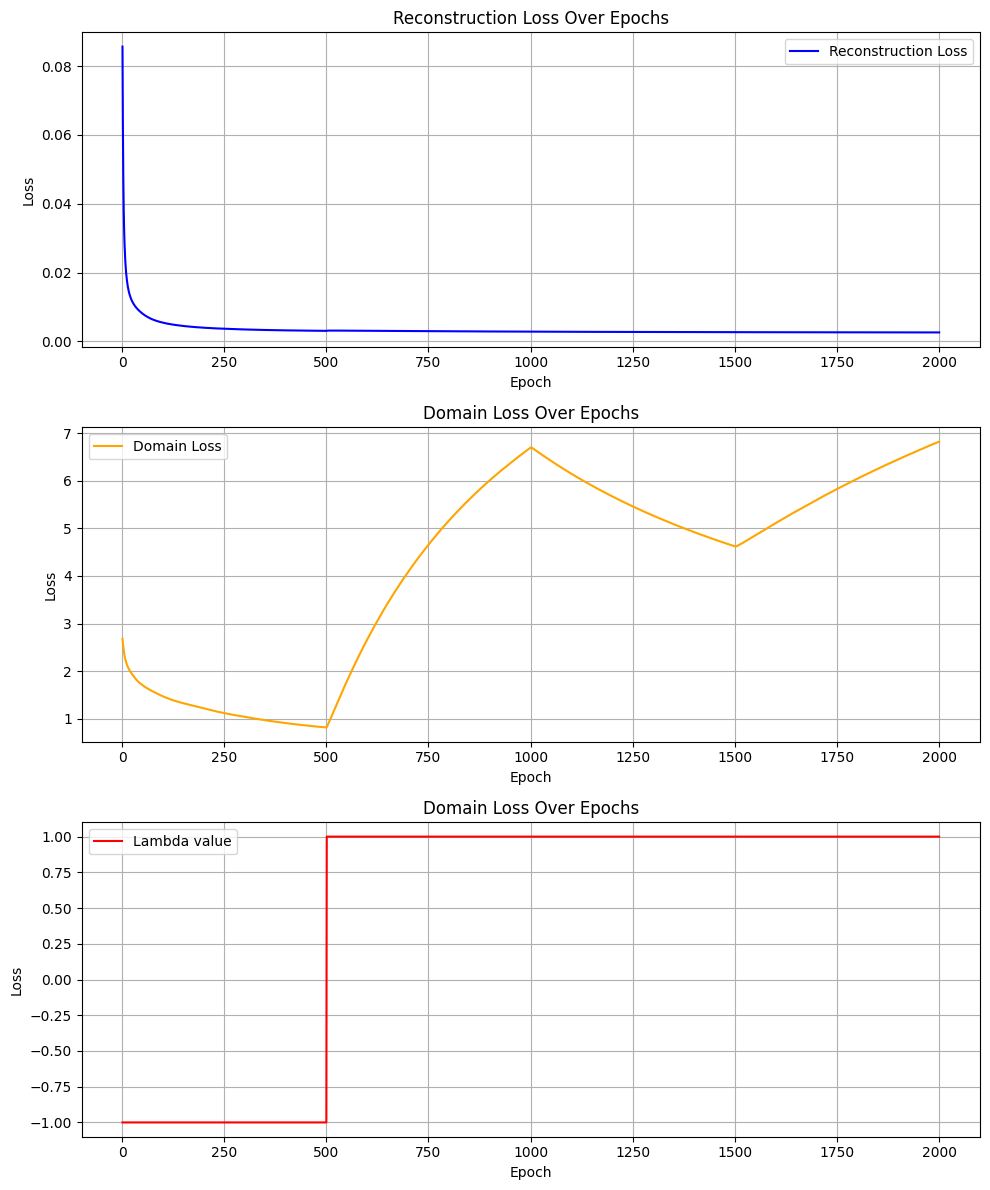

In [10]:
# After training, plot the losses
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot Reconstruction Loss
axs[0].plot(range(1, epoch_count + 1), reconstruction_losses, label='Reconstruction Loss', color='blue')
axs[0].set_title('Reconstruction Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()
axs[0].legend()

# Plot Domain Loss
axs[1].plot(range(1, epoch_count + 1), domain_losses, label='Domain Loss', color='orange')
axs[1].set_title('Domain Loss Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid()
axs[1].legend()

# Plot Domain Loss
axs[2].plot(range(1, epoch_count + 1), lambda_values, label='Lambda value', color='red')
axs[2].set_title('Domain Loss Over Epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()

15/15 [==============================] - 0s 2ms/step
(450, 64)


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


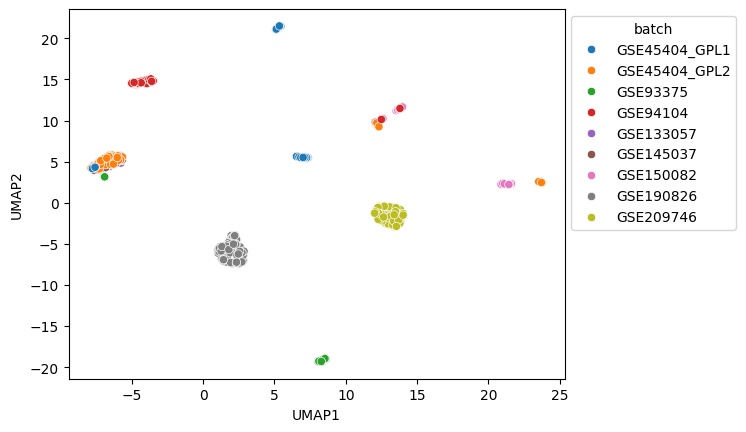

In [74]:
#grab the represetations from the trained model
low_dimensional_representation = encoder.predict(gene_expression_data)

#verify the shape
print(low_dimensional_representation.shape)

#set up the umap

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(low_dimensional_representation)

#checking batch separation
current_label =  adata.obs['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

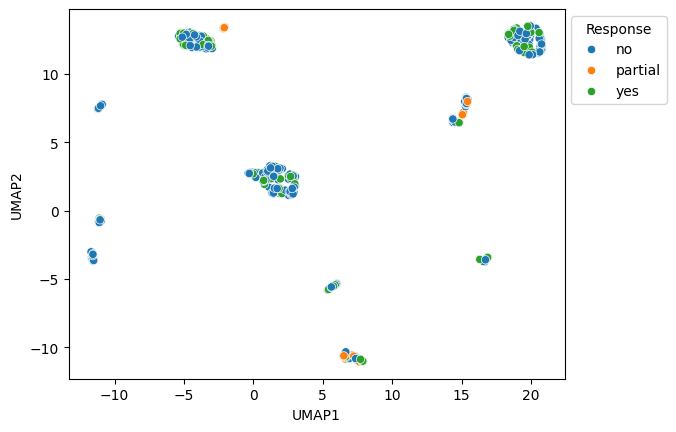

In [13]:
#checking response variable separation
current_label =  adata.obs['Response']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'Response':current_label}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Response')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [14]:
# use the embeddings for random forest classification
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

/tmp/ipykernel_585612/1211444478.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs['Response'][indices]


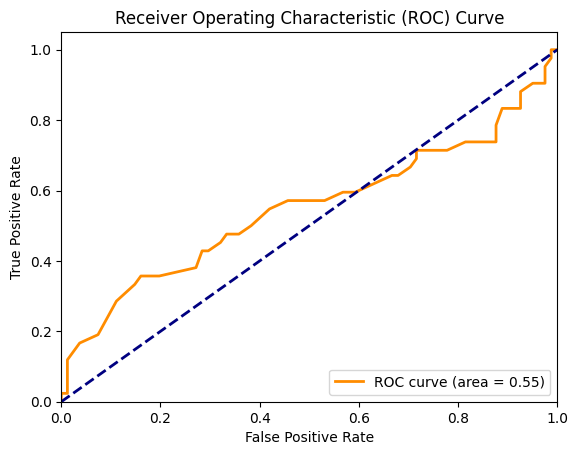

In [15]:
## random forest with original data
indices = [i for i, s in enumerate(adata.obs['Response']) if s in ["yes", "no"]]
y = adata.obs['Response'][indices]
y = [1 if x == "yes" else 0 for x in y]
y = np.array(y)
X = X_data[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (class 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_585612/1434992043.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs['Response'][indices]


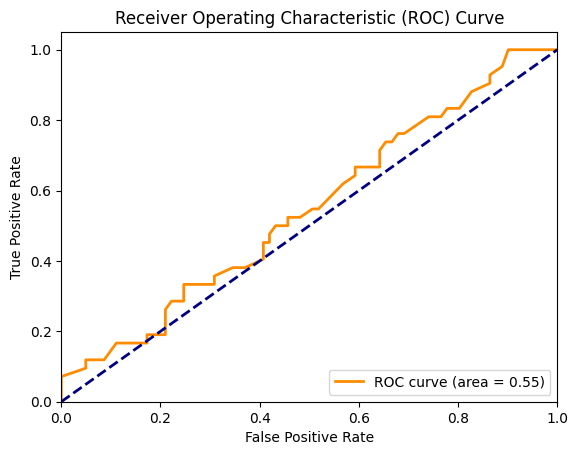

In [16]:
## random forest with transformed data
indices = [i for i, s in enumerate(adata.obs['Response']) if s in ["yes", "no"]]
y = adata.obs['Response'][indices]
y = [1 if x == "yes" else 0 for x in y]
y = np.array(y)
X = low_dimensional_representation[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (class 1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
first_rep.shape
second_rep.shape
third_rep.shape
low_dimensional_representation.shape

(450, 64)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


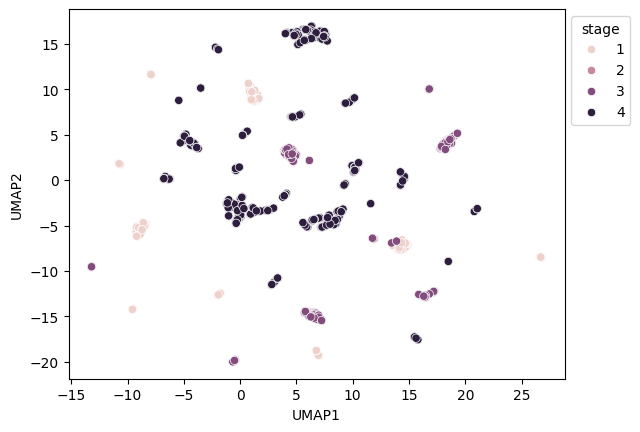

In [59]:
#set up the umap

all_sets = np.vstack((first_rep,second_rep,third_rep,low_dimensional_representation))

umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use

umap_result = umap_model.fit_transform(all_sets)

first = np.repeat(1,first_rep.shape[0])
training_stage = np.concatenate((first,first*2,first*3,first*4))

#checking batch separation
current_label =  adata.obs['batch']
umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'stage':training_stage}
umap_df = pd.DataFrame(data=umap_data)
ax = sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='stage')
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [62]:
from scipy.spatial.distance import pdist
import numpy as np

In [69]:
print(np.mean(pdist(first_rep)))
print(np.mean(pdist(second_rep)))
print(np.mean(pdist(third_rep)))
print(np.mean(pdist(low_dimensional_representation)))

41.7415391277744
62.31731431322231
62.648826385212516
62.31731431322231
